In [350]:
import warnings

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from keras.preprocessing import image


warnings.filterwarnings('ignore')

In [459]:
pd_data = pd.read_csv('../data/multilabel_modified/multilabel_classification_clean.csv')   # reading the csv file
pd_data.head()

,Image_Name,Classes,motorcycle,truck,boat,bus,cycle,person,desert,mountains,sea,sunset,trees,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus person,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus trees,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [460]:
train_dir = "../data/multilabel_modified/train"
val_dir = "../data/multilabel_modified/validation"
test_dir = "../data/multilabel_modified/test"

# Creating Image Data Generator for train, validation and test set
def split_and_trim(labels):
    return [label.strip() for label in labels.split(' ')]

# Apply the function to the Labels column
pd_data['Classes'] = pd_data['Classes'].apply(split_and_trim)

mlb = MultiLabelBinarizer()
multi_hot_labels = mlb.fit_transform(pd_data['Classes'])

# Add multi-hot encoded labels to DataFrame
label_columns = mlb.classes_
for i, label in enumerate(label_columns):
    pd_data[label] = multi_hot_labels[:, i]

train_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
train_image_generator = train_gen.flow_from_dataframe(
    dataframe=pd_data,
    directory=train_dir,
    x_col='Image_Name',
    y_col=['motorcycle', 'truck', 'boat', 'bus', 'cycle', 'person', 'desert', 'mountains', 'sea',
           'sunset', 'trees', 'sitar', 'ektara', 'flutes', 'tabla', 'harmonium'],
    color_mode="rgb",
    class_mode="raw",
    target_size=(224, 224),
    batch_size=32  # to make this tutorial simple
)

val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = val_gen.flow_from_dataframe(
    dataframe=pd_data,
    directory=val_dir,
    x_col='Image_Name',
    y_col=['motorcycle', 'truck', 'boat', 'bus', 'cycle', 'person', 'desert', 'mountains', 'sea',
           'sunset', 'trees', 'sitar', 'ektara', 'flutes', 'tabla', 'harmonium'],
    color_mode="rgb",
    class_mode="raw",
    target_size=(224, 224),
    batch_size=32  # to make this tutorial simple
)


Found 4000 validated image filenames.
Found 2000 validated image filenames.


In [464]:
# Build a custom sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=[224, 224, 3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='sigmoid'))

In [465]:
# Print the model summary
model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_140 (MaxPool  (None, 112, 112, 8)       0         
 ing2D)                                                          
                                                                 
 conv2d_141 (Conv2D)         (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_141 (MaxPool  (None, 56, 56, 16)        0         
 ing2D)                                                          
                                                                 
 flatten_67 (Flatten)        (None, 50176)             0         
                                                                 
 dense_190 (Dense)           (None, 128)             

In [467]:
# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_image_generator, 
                 epochs=5, 
                 verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch = 4000//32, 
                 validation_steps = 2000//32)

Epoch 1/5
125/125 [==============================] - 24s 183ms/step - loss: 0.2787 - accuracy: 0.4893 - val_loss: 0.4779 - val_accuracy: 0.2303
Epoch 2/5
125/125 [==============================] - 25s 201ms/step - loss: 0.2381 - accuracy: 0.5420 - val_loss: 0.5493 - val_accuracy: 0.0827
Epoch 3/5
125/125 [==============================] - 21s 167ms/step - loss: 0.2063 - accuracy: 0.6133 - val_loss: 0.5315 - val_accuracy: 0.1270
Epoch 4/5
125/125 [==============================] - 21s 169ms/step - loss: 0.1762 - accuracy: 0.6768 - val_loss: 0.6321 - val_accuracy: 0.2046
Epoch 5/5
125/125 [==============================] - 21s 168ms/step - loss: 0.1789 - accuracy: 0.7085 - val_loss: 0.7658 - val_accuracy: 0.3135


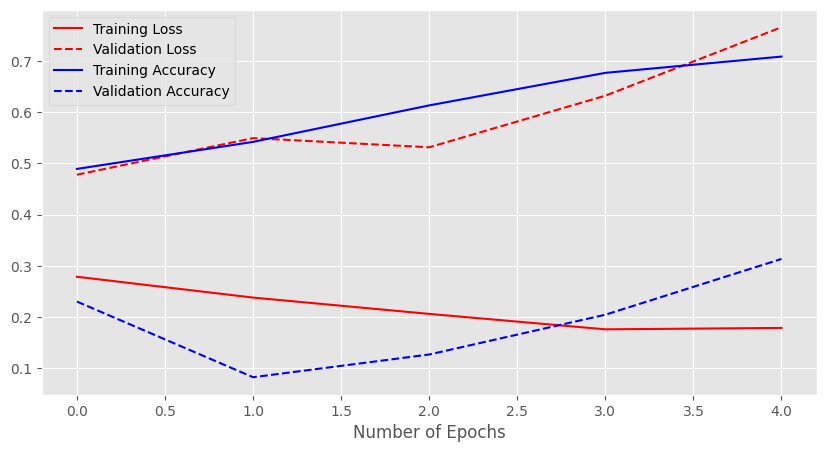

In [468]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [487]:
# Load and preprocess the input image
img_path = val_dir+'/image5063.jpg'  # Replace 'path_to_input_image' with the actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Scale pixel values to [0, 1]

# Make predictions
predictions = model.predict(img_array)

decoded_predictions = [label_columns[i] for i, pred in enumerate(predictions[0]) if pred >= 0.5]

print("Predicted labels:", decoded_predictions)


1/1 [==============================] - 0s 13ms/step
Predicted labels: ['bus', 'desert,mountains']
